# Anomaly detection using non-linear autoencoder based on the reconstruction error

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('data/DSA_features.csv')
data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [3]:
data['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [4]:
filtering_activities = ['lyingRigh', 'lyingBack', 'sitting']
filtered_data = data[data['activity'].isin(filtering_activities)].copy()
filtered_data['abnormal'] = filtered_data['activity'].apply(lambda x: 0 if x in ['lyingRigh', 'lyingBack'] else 1)
filtered_data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,abnormal
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1,1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1,1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1,1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1,1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1,1


In [5]:
le_activity = LabelEncoder()
filtered_data['activity'] = le_activity.fit_transform(filtered_data['activity'])

le_people = LabelEncoder()
filtered_data['people'] = le_people.fit_transform(filtered_data['people'])

filtered_data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people,abnormal
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,2,0,1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,2,0,1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,2,0,1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,2,0,1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,2,0,1


In [6]:
X = filtered_data.drop(['activity', 'abnormal'], axis=1).values
y = filtered_data['abnormal'].values
print(X.shape, y.shape)

(1440, 271) (1440,)


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled[y == 0], y[y == 0], test_size=0.3, random_state=42)
X_test, y_test = np.concatenate([X_test, X_scaled[y == 1]], axis=0), np.concatenate([y_test, y[y == 1]], axis=0)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

(672, 271) (672,) (768, 271) (768,)


In [8]:
class DSADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
train_dataset = DSADataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = DSADataset(X_test_tensor, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
class AsymmetricAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(AsymmetricAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
net = AsymmetricAutoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_loss += loss.item() * inputs.size(0)
        train_total += inputs.size(0)
        
    train_losses.append(train_loss / train_total)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}')

Epoch [100/1000], Train Loss: 0.1137
Epoch [200/1000], Train Loss: 0.0617
Epoch [300/1000], Train Loss: 0.0391
Epoch [400/1000], Train Loss: 0.0262
Epoch [500/1000], Train Loss: 0.0295
Epoch [600/1000], Train Loss: 0.0142
Epoch [700/1000], Train Loss: 0.0308
Epoch [800/1000], Train Loss: 0.0127
Epoch [900/1000], Train Loss: 0.0194
Epoch [1000/1000], Train Loss: 0.0064


In [16]:
net.eval()
with torch.no_grad():
    reconstructions = net(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

min_error = torch.min(reconstruction_errors).item()
max_error = torch.max(reconstruction_errors).item()
thresholds = np.linspace(min_error, max_error, 100)

accuracies = []

for threshold in thresholds:
    anomalies = (reconstruction_errors > threshold).float()
    accuracy = torch.sum(anomalies == torch.FloatTensor(y_test)).item() / len(y_test)
    accuracies.append(accuracy)

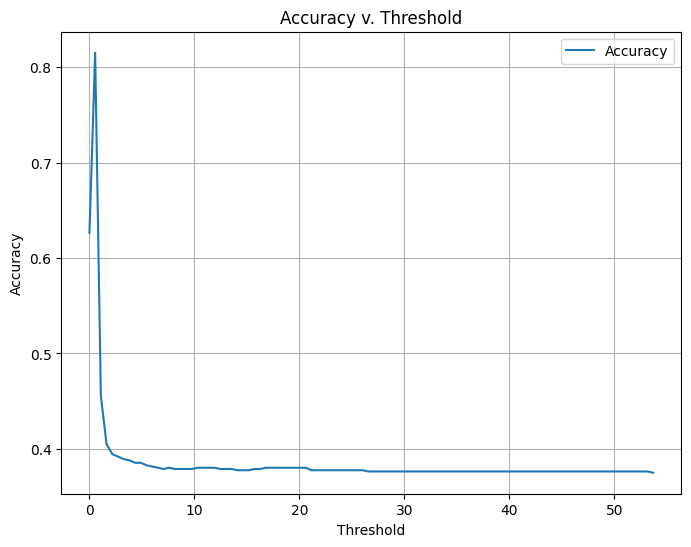

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy v. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
net.eval()
with torch.no_grad():
    reconstructions = net(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

threshold = torch.max(torch.mean((net(X_train_tensor) - X_train_tensor) ** 2, dim=1))
print("Threshold: ", threshold.item())

anomalies = (reconstruction_errors > threshold).float()
accuracy = torch.sum(anomalies == torch.FloatTensor(y_test)).item() / len(y_test)
print("Accuracy: ", accuracy)

Threshold:  0.17516180872917175
Accuracy:  0.9166666666666666
